In [170]:
import pandas as pd
import numpy as np
from pathlib import Path

# path to the CSV you wrote after imputation
df = pd.read_csv("../data/processed/eda_compact_encoding.csv", low_memory=False)

# peek
print(df.shape)
df.head(2)

(8054, 132)


,Título,Num_Drives,Disco duro_Capacidad de memoria SSD,Alimentación_Capacidad de la batería,Pantalla_Displayglas_flag,Gráfica_GPU_flag,Pantalla_Tecnología de la pantalla_flag,Conectividad_Lector de tarjetas_flag,Cámara_Webcam_flag,Precio_min,...,Eq_Other,Multi_Drive_flag,Sistema operativo_Sistema operativo_freq,Sistema operativo_Sistema operativo_count,Procesador_Nombre en clave del procesador_freq,Procesador_Nombre en clave del procesador_count,RAM_Tipo de RAM_freq,RAM_Tipo de RAM_count,Gráfica_Tarjeta gráfica_freq,Gráfica_Tarjeta gráfica_count
0,"Apple MacBook Air 13"" 2024 M3",1.0,512.0,4800.0,0.0,0.0,1.0,1.0,1.0,1026.53,...,0.0,0.0,0.271542,2187,0.303576,2445,0.281972,2271,0.16737,1348
1,"Apple MacBook Air 15"" 2024 M3",1.0,512.0,4800.0,0.0,0.0,1.0,1.0,1.0,1270.42,...,0.0,0.0,0.271542,2187,0.303576,2445,0.281972,2271,0.16737,1348


### EDA reminders

- **RAM** clustered at 8 GB & 16 GB  
- **SSD** modes at 256 GB, 512 GB, 1 TB, 2 TB  
- **Screen size** around 14–15"  
- **Resolutions** form two clusters: 1920×1080 and 3840×2160  
- **CPU clock** peaks at ~1.3 GHz (low‑power) & ~2.5 GHz (base) & ~4 GHz (boost)  

We’ll now build features that capture:  
1. **Log‑scale** of skewed specs  
2. **Combined performance metrics** (CPU_perf)  
3. **Portability metrics** (Wh per kg, pixel density)  
4. **Resolution tier flags** (FHD vs 4K)  
5. **Ratios** (SSD per RAM, etc.)  

In [171]:
def add_features(df):
    df = df.copy()
    
    # 1. Pixel density (ppi)
    df['ppi'] = (
        np.sqrt(df['Res_Horiz_px']**2 + df['Res_Vert_px']**2)
        / df['Pantalla_Tamaño_pulg']
    )
    
    # 2. CPU performance proxy: base GHz × cores
    df['CPU_perf'] = df['CPU_GHz'] * df['Procesador_Cores']
    
    # 3. Battery‑to‑weight: autonomy (h) ×  Wh per battery  
    #    Note: if you have Battery_Wh column; else skip
    if 'Alimentación_Capacidad de la batería' in df:
        df['Batt_Wh_per_kg'] = (
            df['Bateria_Autonomia_h'] * df['Alimentación_Capacidad de la batería']
            / df['Peso_kg']
        )
    
    # 4. Log‑transforms of heavy‑tailed specs
    for c in ['RAM_GB', 'Disco duro_Capacidad de memoria SSD']:
        df[f'log_{c}'] = np.log1p(df[c])
    
    # 5. Resolution tier flag
    df['Is_4K'] = ((df['Res_Horiz_px'] >= 3840) & (df['Res_Vert_px'] >= 2160)).astype(int)
    df['Is_FHD'] = ((df['Res_Horiz_px'] == 1920) & (df['Res_Vert_px'] == 1080)).astype(int)
    
    # 6. Storage per RAM ratio
    df['SSD_per_RAM'] = df['Disco duro_Capacidad de memoria SSD'] / df['RAM_GB']

    #log_SSD_GB
    df['log_SSD_GB'] = np.log1p(df['Disco duro_Capacidad de memoria SSD'])
    
    return df

In [172]:
df_fe = add_features(df)

# After running your add_features(df) step:

df_fe = add_features(df)

# List all candidate new features
candidate_new = [
    'ppi',
    'CPU_perf',
    'Batt_Wh_per_kg',
    'log_RAM_GB',
    'log_SSD_GB',
    'Is_4K',
    'Is_FHD',
    'SSD_per_RAM'
]

# Filter to those that actually exist in df_fe
new_cols = [c for c in candidate_new if c in df_fe.columns]
print("New features present:", new_cols)

# Display descriptive stats for those features
display(df_fe[new_cols].describe().T)

New features present: ['ppi', 'CPU_perf', 'Batt_Wh_per_kg', 'log_RAM_GB', 'log_SSD_GB', 'Is_4K', 'Is_FHD', 'SSD_per_RAM']


/Users/gonzalofernandezdecordoba/Desktop/ml-computers-app/.venv/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max
ppi,8054.0,1.524066e+02,28.181965,100.454670,141.211998,141.211998,141.509717,3.234508e+02
CPU_perf,8054.0,1.080426e+01,13.276464,0.002000,0.037950,9.000000,12.600000,7.800000e+01
Batt_Wh_per_kg,8054.0,2.974386e+04,17065.617092,1300.813008,24000.000000,28235.294118,30000.000000,2.510182e+05
log_RAM_GB,8054.0,2.881946e+00,0.499006,0.000000,2.833213,2.833213,3.218876,5.549076e+00
log_SSD_GB,8054.0,6.414573e+00,0.602032,2.197225,6.240276,6.240276,6.908755,8.987322e+00
Is_4K,8054.0,9.187981e-03,0.095419,0.000000,0.000000,0.000000,0.000000,1.000000e+00
Is_FHD,8054.0,7.853241e-01,0.410623,0.000000,1.000000,1.000000,1.000000,1.000000e+00
SSD_per_RAM,8054.0,inf,NaN,1.000000,31.250000,32.000000,62.500000,inf


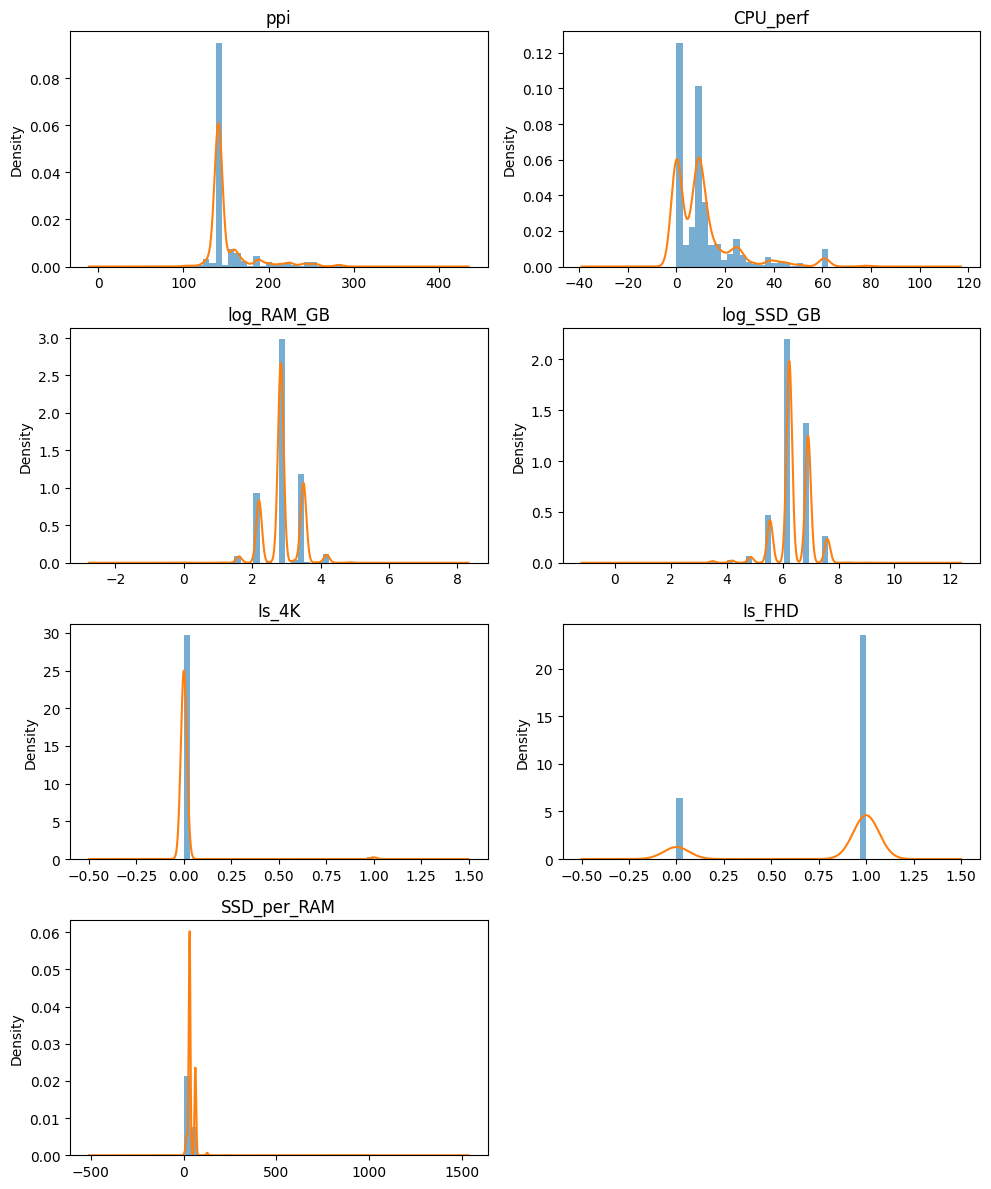

In [173]:
import numpy as np
import matplotlib.pyplot as plt

# ensure new_cols is defined, e.g.
new_cols = ['ppi', 'CPU_perf', 'log_RAM_GB', 'log_SSD_GB', 'Is_4K', 'Is_FHD', 'SSD_per_RAM']

plt.figure(figsize=(10, 12))
for i, col in enumerate(new_cols, 1):
    ax = plt.subplot(4, 2, i)
    # replace infinities with NaN, then drop them
    data = df_fe[col].replace([np.inf, -np.inf], np.nan).dropna()
    ax.hist(data, bins=30, density=True, alpha=0.6)
    data.plot(kind='kde', ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

In [174]:
# ─── 2. Define your feature‐engineering function ─────────────────────
def add_features(df):
    df = df.copy()
    # a) Pixel density
    df['ppi'] = (
        np.sqrt(df['Res_Horiz_px']**2 + df['Res_Vert_px']**2)
        / df['Pantalla_Tamaño_pulg']
    )
    # b) CPU performance proxy
    df['CPU_perf'] = df['CPU_GHz'] * df['Procesador_Cores']
    # c) Log‐transforms
    df['log_RAM_GB'] = np.log1p(df['RAM_GB'])
    df['log_SSD_GB'] = np.log1p(df['Disco duro_Capacidad de memoria SSD'])
    # d) Resolution flags
    df['Is_4K']  = ((df['Res_Horiz_px']>=3840)&(df['Res_Vert_px']>=2160)).astype(int)
    df['Is_FHD'] = ((df['Res_Horiz_px']==1920)&(df['Res_Vert_px']==1080)).astype(int)
    # e) Storage/RAM ratio
    df['SSD_per_RAM'] = df['Disco duro_Capacidad de memoria SSD'] / df['RAM_GB']
    return df

# ─── 3. Apply it ──────────────────────────────────────────────────────
df_fe = add_features(df)

# ─── 4. Clean up any infinities in the ratios ────────────────────────
for col in ['SSD_per_RAM','ppi','CPU_perf','log_RAM_GB','log_SSD_GB']:
    df_fe[col] = df_fe[col].replace([np.inf, -np.inf], np.nan)

# (Option A) Drop any rows where these new cols are still NaN/inf:
df_fe = df_fe.dropna(subset=['ppi','CPU_perf','log_RAM_GB','log_SSD_GB','SSD_per_RAM'])

# ─── 5. Quick sanity check ────────────────────────────────────────────
print("New features present:", [c for c in
      ['ppi','CPU_perf','log_RAM_GB','log_SSD_GB','Is_4K','Is_FHD','SSD_per_RAM']
      if c in df_fe])
print(df_fe[['ppi','CPU_perf','log_RAM_GB','log_SSD_GB','SSD_per_RAM']].describe().T)

# ─── 6. Save the augmented dataset ───────────────────────────────────
OUT_PATH = Path("../data/processed/eda_with_new_features.csv")
df_fe.to_csv(OUT_PATH, index=False)
print("✅ Saved augmented data with new features to:", OUT_PATH, "shape =", df_fe.shape)

New features present: ['ppi', 'CPU_perf', 'log_RAM_GB', 'log_SSD_GB', 'Is_4K', 'Is_FHD', 'SSD_per_RAM']
              count        mean        std         min         25%  \
ppi          8049.0  152.413584  28.189336  100.454670  141.211998   
CPU_perf     8049.0   10.809851  13.278389    0.002000    0.038400   
log_RAM_GB   8049.0    2.883737   0.493962    0.405465    2.833213   
log_SSD_GB   8049.0    6.414681   0.602203    2.197225    6.240276   
SSD_per_RAM  8049.0   39.996520  26.095085    1.000000   31.250000   

                    50%         75%          max  
ppi          141.211998  141.509717   323.450782  
CPU_perf       9.000000   12.600000    78.000000  
log_RAM_GB     2.833213    3.218876     5.549076  
log_SSD_GB     6.240276    6.908755     8.987322  
SSD_per_RAM   32.000000   62.500000  1024.000000  
✅ Saved augmented data with new features to: ../data/processed/eda_with_new_features.csv shape = (8049, 139)


In [175]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor

# 1️⃣ Load your featurized dataset
IN = Path("../data/processed/eda_with_new_features.csv")
df = pd.read_csv(IN, low_memory=False)

# ensure you have a log‐price column
df['LogPrice'] = np.log1p(df['Precio_avg'])

# your seven derived specs
features = ['ppi','CPU_perf','log_RAM_GB','log_SSD_GB','Is_4K','Is_FHD','SSD_per_RAM']

# 2️⃣ Correlation with log‐price
corrs = df[features + ['LogPrice']].corr()['LogPrice'].abs().drop('LogPrice').sort_values()
print("∘ |Pearson ρ| with LogPrice:\n", corrs, "\n")

# 3️⃣ Quick RandomForest importances
#    fillna(0) just for this quick check—your RF can handle some missing vs plain Ridge
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(df[features].fillna(0), df['LogPrice'])
importances = pd.Series(rf.feature_importances_, index=features).sort_values()
print("∘ RF feature importances:\n", importances, "\n")

# 4️⃣ Decide what to drop
#    e.g. SSD_per_RAM has the lowest corr AND the lowest RF importance here
to_drop = ['SSD_per_RAM', 'Is_4K', 'Is_FHD', 'SSD_per_RAM']
print("∘ Dropping features:", to_drop, "\n")

# 5️⃣ Create a pruned dataframe and save
df_selected = df.drop(columns=to_drop)
OUT = Path("../data/processed/featurized_selected.csv")
df_selected.to_csv(OUT, index=False)
print(f"✅ Saved selected specs to {OUT} (shape = {df_selected.shape})")

∘ |Pearson ρ| with LogPrice:
 SSD_per_RAM    0.053434
Is_4K          0.127986
ppi            0.284306
Is_FHD         0.296441
CPU_perf       0.300816
log_SSD_GB     0.485833
log_RAM_GB     0.580755
Name: LogPrice, dtype: float64 

∘ RF feature importances:
 Is_4K          0.001514
Is_FHD         0.006518
SSD_per_RAM    0.034561
log_SSD_GB     0.036217
ppi            0.170123
CPU_perf       0.287803
log_RAM_GB     0.463264
dtype: float64 

∘ Dropping features: ['SSD_per_RAM', 'Is_4K', 'Is_FHD', 'SSD_per_RAM', 'log_SSD_GB'] 

✅ Saved selected specs to ../data/processed/featurized_selected.csv (shape = (8049, 136))
